# 1. Project Overview & Business Understanding



The head of a new movie studio requires data-driven recommendations to guide initial film production choices, specifically aiming to maximize worldwide box office success.



Key Questions to be Answered:



1. Which film genres yield the highest average worldwide revenue?


2. How does audience reception (IMDB rating) correlate with financial success?


3. Is there an optimal film runtime that maximizes gross earnings?


4. How consistent are audience ratings within the highest-grossing film genres?


5. Are the observed differences in average genre revenue statistically significant, or merely due to random chance?

2. Data Understanding and Acquisition

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3

In [93]:
# Establish connection to the IMDB database
conn = sqlite3.connect('im.db')
# Load the Box Office Mojo (BOM) gross revenue data
df = pd.read_csv('bom.movie_gross.csv')

In [94]:
# Display all tables in the database
query1 = """
SELECT * 
FROM sqlite_master
 WHERE type = 'table';
 """
print(pd.read_sql_query(query1, conn))

    type           name       tbl_name  rootpage  \
0  table   movie_basics   movie_basics         2   
1  table      directors      directors         3   
2  table      known_for      known_for         4   
3  table     movie_akas     movie_akas         5   
4  table  movie_ratings  movie_ratings         6   
5  table        persons        persons         7   
6  table     principals     principals         8   
7  table        writers        writers         9   
8  table        Revenue        Revenue     41369   

                                                 sql  
0  CREATE TABLE "movie_basics" (\n"movie_id" TEXT...  
1  CREATE TABLE "directors" (\n"movie_id" TEXT,\n...  
2  CREATE TABLE "known_for" (\n"person_id" TEXT,\...  
3  CREATE TABLE "movie_akas" (\n"movie_id" TEXT,\...  
4  CREATE TABLE "movie_ratings" (\n"movie_id" TEX...  
5  CREATE TABLE "persons" (\n"person_id" TEXT,\n ...  
6  CREATE TABLE "principals" (\n"movie_id" TEXT,\...  
7  CREATE TABLE "writers" (\n"movie_id"

In [95]:
print("\nBox Office Mojo Data Preview:")
# Preview BOM data structure
print(df.head())


Box Office Mojo Data Preview:
                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010  


3. Data Preparation and Cleaning

This section integrates and cleans the data from the IMDB database and the Box Office Mojo CSV file. The key step is joining movie metadata (runtime, genre, rating) with financial gross data.

In [96]:
# This creates a 'Revenue' table inside the im.db


df.to_sql("Revenue", conn, if_exists="replace", index=False)

3387

In [97]:
# Data Merging: SQL Query to join all necessary tables 
query2= """ 
SELECT mb.movie_id, r.title, mb.original_title,r.year, mb.runtime_minutes,mb.genres, r.studio, r.domestic_gross, r.foreign_gross, mr.averagerating, mr.numvotes
FROM movie_basics AS mb
JOIN Revenue AS r
ON mb.primary_title = r.title
JOIN movie_ratings AS mr
ON mb.movie_id =  mr.movie_id;
"""
df1=pd.read_sql_query(query2, conn)
df1.head()
df1.to_csv('Data_for_Analysis.csv', index=False) # Export merged data for further analysis

In [98]:
df1.describe()

,year,runtime_minutes,domestic_gross,averagerating,numvotes
count,3027.000000,2980.000000,3.005000e+03,3027.000000,3.027000e+03
mean,2014.077635,107.217114,3.064033e+07,6.457582,6.170030e+04
std,2.442245,20.073886,6.671629e+07,1.012277,1.255132e+05
min,2010.000000,3.000000,1.000000e+02,1.600000,5.000000e+00
25%,2012.000000,94.000000,1.390000e+05,5.900000,2.117000e+03
50%,2014.000000,105.000000,2.000000e+06,6.600000,1.310900e+04
75%,2016.000000,118.000000,3.250000e+07,7.100000,6.276550e+04
max,2018.000000,272.000000,7.001000e+08,9.200000,1.841066e+06


In [99]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3027 entries, 0 to 3026
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3027 non-null   object 
 1   title            3027 non-null   object 
 2   original_title   3027 non-null   object 
 3   year             3027 non-null   int64  
 4   runtime_minutes  2980 non-null   float64
 5   genres           3020 non-null   object 
 6   studio           3024 non-null   object 
 7   domestic_gross   3005 non-null   float64
 8   foreign_gross    1832 non-null   object 
 9   averagerating    3027 non-null   float64
 10  numvotes         3027 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 260.3+ KB


In [100]:
# convert foreign_gross to Float and fill value with zero  thinking is any null value means Movie didnt sell overseas
df1['foreign_gross'] = pd.to_numeric(
    df['foreign_gross']
        .astype(str)
        .str.replace(',', '', regex=True),
    errors='coerce'
).fillna(0)

In [101]:
df1['domestic_gross'] = df1['domestic_gross'].fillna(0) # fill null domestic gross with zero

In [102]:
df1['Total_revenues'] = df1['domestic_gross'] + df1['foreign_gross'] # Total Revenue Calculation
df1['Total_revenues_mil'] = df1['Total_revenues'] / 1_000_000  # Convert to millions

In [103]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3027 entries, 0 to 3026
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            3027 non-null   object 
 1   title               3027 non-null   object 
 2   original_title      3027 non-null   object 
 3   year                3027 non-null   int64  
 4   runtime_minutes     2980 non-null   float64
 5   genres              3020 non-null   object 
 6   studio              3024 non-null   object 
 7   domestic_gross      3027 non-null   float64
 8   foreign_gross       3027 non-null   float64
 9   averagerating       3027 non-null   float64
 10  numvotes            3027 non-null   int64  
 11  Total_revenues      3027 non-null   float64
 12  Total_revenues_mil  3027 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 307.6+ KB


In [104]:
# Impute missing runtime with the MODE robust analysis
median_runtime = df1['runtime_minutes'].median() 
df1['runtime_minutes'].fillna(median_runtime, inplace=True)

In [105]:
mode_genres = df1['genres'].mode()
df1['genres'].fillna(mode_genres,inplace=True)

In [106]:
# Impute missing runtime with the median for robust analysis
median_runtime = df1['runtime_minutes'].median()
df1['runtime_minutes'].fillna(median_runtime, inplace=True)

In [107]:
# Filter out films with 0 revenue 
df1 = df1[df1['Total_revenues_mil'] > 0]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3019 entries, 0 to 3026
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            3019 non-null   object 
 1   title               3019 non-null   object 
 2   original_title      3019 non-null   object 
 3   year                3019 non-null   int64  
 4   runtime_minutes     3019 non-null   float64
 5   genres              3012 non-null   object 
 6   studio              3017 non-null   object 
 7   domestic_gross      3019 non-null   float64
 8   foreign_gross       3019 non-null   float64
 9   averagerating       3019 non-null   float64
 10  numvotes            3019 non-null   int64  
 11  Total_revenues      3019 non-null   float64
 12  Total_revenues_mil  3019 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 330.2+ KB


In [108]:
# 1. Fill missing values with 'Unknown' for statistical accuracy
# This preserves the N=3019 sample size for correlation analysis
df1['genres'] = df1['genres'].fillna('Unknown')
df1['studio'] = df1['studio'].fillna('Unknown')
print(f"Final Clean Rows for Analysis: {len(df1)}")
df1.info()

Final Clean Rows for Analysis: 3019
<class 'pandas.core.frame.DataFrame'>
Index: 3019 entries, 0 to 3026
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            3019 non-null   object 
 1   title               3019 non-null   object 
 2   original_title      3019 non-null   object 
 3   year                3019 non-null   int64  
 4   runtime_minutes     3019 non-null   float64
 5   genres              3019 non-null   object 
 6   studio              3019 non-null   object 
 7   domestic_gross      3019 non-null   float64
 8   foreign_gross       3019 non-null   float64
 9   averagerating       3019 non-null   float64
 10  numvotes            3019 non-null   int64  
 11  Total_revenues      3019 non-null   float64
 12  Total_revenues_mil  3019 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 330.2+ KB


## `4. DATA ANALYSIS`

Calculations to derive the key insights for the studio.

***Analysis 1: Genre vs. Revenue***

In [109]:
# Explode genres to treat each genre separately (e.g., 'Action, Drama' becomes two rows)
genre_exploded = df1.assign(genres=df1['genres'].str.split(',')).explode('genres')
genre_exploded['genres'] = genre_exploded['genres'].str.strip()
genre_exploded

,movie_id,title,original_title,year,runtime_minutes,genres,studio,domestic_gross,foreign_gross,averagerating,numvotes,Total_revenues,Total_revenues_mil
0,tt0315642,Wazir,Wazir,2016,103.0,Action,Relbig.,1100000.0,652000000.0,7.1,15378,653100000.0,653.100
0,tt0315642,Wazir,Wazir,2016,103.0,Crime,Relbig.,1100000.0,652000000.0,7.1,15378,653100000.0,653.100
0,tt0315642,Wazir,Wazir,2016,103.0,Drama,Relbig.,1100000.0,652000000.0,7.1,15378,653100000.0,653.100
1,tt0337692,On the Road,On the Road,2012,124.0,Adventure,IFC,744000.0,691300000.0,6.1,37886,692044000.0,692.044
1,tt0337692,On the Road,On the Road,2012,124.0,Drama,IFC,744000.0,691300000.0,6.1,37886,692044000.0,692.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3023,tt9447594,The Gambler,The Gambler,2014,121.0,Thriller,Par.,33700000.0,0.0,6.1,10,33700000.0,33.700
3024,tt9816988,Gold,Tala,2017,105.0,Drama,Wein.,7200000.0,0.0,5.2,26,7200000.0,7.200
3025,tt9851050,Sisters,Sisters,2015,105.0,Action,Uni.,87000000.0,0.0,4.7,14,87000000.0,87.000
3025,tt9851050,Sisters,Sisters,2015,105.0,Drama,Uni.,87000000.0,0.0,4.7,14,87000000.0,87.000


In [110]:
# Calculate the average revenue per genre and find the top 10
genre_revenue = genre_exploded.groupby('genres')['Total_revenues_mil'].mean().sort_values(ascending=False)
top_10_genres = genre_revenue.head(10)
print("Top 10 Genres by Average Revenue:")
print(top_10_genres)

Top 10 Genres by Average Revenue:
genres
Sci-Fi       176.893116
Adventure    146.838156
Animation    133.408463
Fantasy      108.596204
Action       107.783771
Family       102.756261
Unknown       79.658428
Comedy        78.715239
Sport         75.087006
Thriller      72.819435
Name: Total_revenues_mil, dtype: float64


***Analysis 2: Rating vs. Revenue (Correlation)***

In [111]:
# Calculate the R value
correlation = df1['Total_revenues_mil'].corr(df1['averagerating']) # type: ignore
print(f"Correlation (R) between Average Rating and Total Revenues: {correlation:.4f}")

Correlation (R) between Average Rating and Total Revenues: 0.0759


***Analysis 3: Optimal Runtime***

In [112]:
# find the maximum movie runtime
max_runtime = df1['runtime_minutes'].max()

# create 10-minute intervals starting from 60 minutes
runtime_bins = range(60, int(max_runtime) + 10, 10)

# put movies into runtime groups
df1['runtime_group'] = pd.cut(df1['runtime_minutes'], runtime_bins)

# calculate average revenue for each runtime group
runtime_revenue = df1.groupby('runtime_group')['Total_revenues'].mean()

runtime_revenue

C:\Users\user\AppData\Local\Temp\ipykernel_16760\2708765697.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_revenue = df1.groupby('runtime_group')['Total_revenues'].mean()


runtime_group
(60, 70]      4.737127e+07
(70, 80]      7.308220e+07
(80, 90]      5.994548e+07
(90, 100]     6.899614e+07
(100, 110]    6.975459e+07
(110, 120]    7.559608e+07
(120, 130]    8.022824e+07
(130, 140]    1.049263e+08
(140, 150]    1.140464e+08
(150, 160]    7.388028e+07
(160, 170]    1.523652e+08
(170, 180]    4.240043e+07
(180, 190]    1.756811e+08
(190, 200]    3.557000e+06
(200, 210]             NaN
(210, 220]             NaN
(220, 230]             NaN
(230, 240]             NaN
(240, 250]             NaN
(250, 260]             NaN
(260, 270]             NaN
(270, 280]    1.152000e+05
Name: Total_revenues, dtype: float64

In [113]:
# Creates runtime groups
max_runtime = df1['runtime_minutes'].max()
bins = range(60, int(max_runtime) + 10, 10)
df1['runtime_group'] = pd.cut(df1['runtime_minutes'], bins)
# Average revenues by runtime group
runtime_revenue = df1.groupby('runtime_group')['Total_revenues'].mean()
# Find best runtime range
optimal_runtime_range = runtime_revenue.idxmax()
print (runtime_revenue, optimal_runtime_range)


runtime_group
(60, 70]      4.737127e+07
(70, 80]      7.308220e+07
(80, 90]      5.994548e+07
(90, 100]     6.899614e+07
(100, 110]    6.975459e+07
(110, 120]    7.559608e+07
(120, 130]    8.022824e+07
(130, 140]    1.049263e+08
(140, 150]    1.140464e+08
(150, 160]    7.388028e+07
(160, 170]    1.523652e+08
(170, 180]    4.240043e+07
(180, 190]    1.756811e+08
(190, 200]    3.557000e+06
(200, 210]             NaN
(210, 220]             NaN
(220, 230]             NaN
(230, 240]             NaN
(240, 250]             NaN
(250, 260]             NaN
(260, 270]             NaN
(270, 280]    1.152000e+05
Name: Total_revenues, dtype: float64 (180, 190]


C:\Users\user\AppData\Local\Temp\ipykernel_16760\3378044533.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_revenue = df1.groupby('runtime_group')['Total_revenues'].mean()


In [114]:
print(f"Optimal Runtime Range (Highest Average Revenue): {optimal_runtime_range}")

Optimal Runtime Range (Highest Average Revenue): (180, 190]


***Analysis 4: Rating Consistency Within Top Genres***

While the overall correlation between rating and revenue is weak, this step investigates if the most profitable genres maintain a more consistent rating floor (less variability) compared to other genres.

In [115]:
# 1. Get the list of the top 10 genres:
top_10_genre_list = top_10_genres.index.tolist()
# 2. Filter the exploded DataFrame:
df_top_genre_ratings = genre_exploded[genre_exploded['genres'].isin(top_10_genre_list)]
#print(f"Prepared {len(df_top_genre_ratings)} rows for top genre rating distribution analysis.")
df_top_genre_ratings

,movie_id,title,original_title,year,runtime_minutes,genres,studio,domestic_gross,foreign_gross,averagerating,numvotes,Total_revenues,Total_revenues_mil
0,tt0315642,Wazir,Wazir,2016,103.0,Action,Relbig.,1100000.0,652000000.0,7.1,15378,653100000.0,653.100
1,tt0337692,On the Road,On the Road,2012,124.0,Adventure,IFC,744000.0,691300000.0,6.1,37886,692044000.0,692.044
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,Adventure,Fox,58200000.0,664300000.0,7.3,275300,722500000.0,722.500
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,Comedy,Fox,58200000.0,664300000.0,7.3,275300,722500000.0,722.500
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,Action,Uni.,26300000.0,535700000.0,6.5,105116,562000000.0,562.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,tt9392532,Neighbors,Neighbors,2014,90.0,Comedy,Uni.,150200000.0,0.0,7.6,18,150200000.0,150.200
3023,tt9447594,The Gambler,The Gambler,2014,121.0,Action,Par.,33700000.0,0.0,6.1,10,33700000.0,33.700
3023,tt9447594,The Gambler,The Gambler,2014,121.0,Sci-Fi,Par.,33700000.0,0.0,6.1,10,33700000.0,33.700
3023,tt9447594,The Gambler,The Gambler,2014,121.0,Thriller,Par.,33700000.0,0.0,6.1,10,33700000.0,33.700


## `4. Analysis 5: Hypothesis Testing (ANOVA)`

To ensure the observed revenue differences between genres are not due to random chance, we perform a One-Way Analysis of Variance (ANOVA).

**Hypothesis Test:**
* **Null Hypothesis ($H_0$):** The average worldwide revenue is the same across all major film genres
* **Alternative Hypothesis ($H_A$):** At least one genre has an average worldwide revenue that is statistically different from the others.
* **Significance Level ($\alpha$):** $0.05$

In [116]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
# 1. Prepare the data: Use the top 15 most frequent genres for a relevant and robust test.
top_15_genres_list = genre_exploded['genres'].value_counts().head(15).index.tolist()
df_anova = genre_exploded[genre_exploded['genres'].isin(top_15_genres_list)]
# 2. Run the ANOVA test
formula = 'Total_revenues_mil ~ C(genres)'
lm = ols(formula, data=df_anova).fit()
anova_table = sm.stats.anova_lm(lm, typ=2)
# Extract and print the p-value
anova_p_value = anova_table['PR(>F)'].iloc[0]
print(anova_table)
print(f"\n--- ANOVA P-Value Result ---")
print(f"P-value for Genre Revenue differences: {anova_p_value:.6f}")

# 3. Check P-value against alpha=0.05
if anova_p_value < 0.05:
    print("\nDecision: P-value is less than 0.05. We REJECT the Null Hypothesis (H0).")
    print("Interpretation: The differences in average revenue between major genres are statistically significant.")
else:
     print("Decision: P-value is greater than 0.05. We FAIL TO REJECT the Null Hypothesis (H0).")
     print("Interpretation: Differences are not statistically significant.")

                 sum_sq      df          F        PR(>F)
C(genres)  5.600847e+06    14.0  22.883069  2.178778e-58
Residual   1.151943e+08  6589.0        NaN           NaN

--- ANOVA P-Value Result ---
P-value for Genre Revenue differences: 0.000000

Decision: P-value is less than 0.05. We REJECT the Null Hypothesis (H0).
Interpretation: The differences in average revenue between major genres are statistically significant.


## `5. VISUALIZATION` 

Visual representations of the analysis results

***Visualization 1: Top 10 Genres by Revenue***

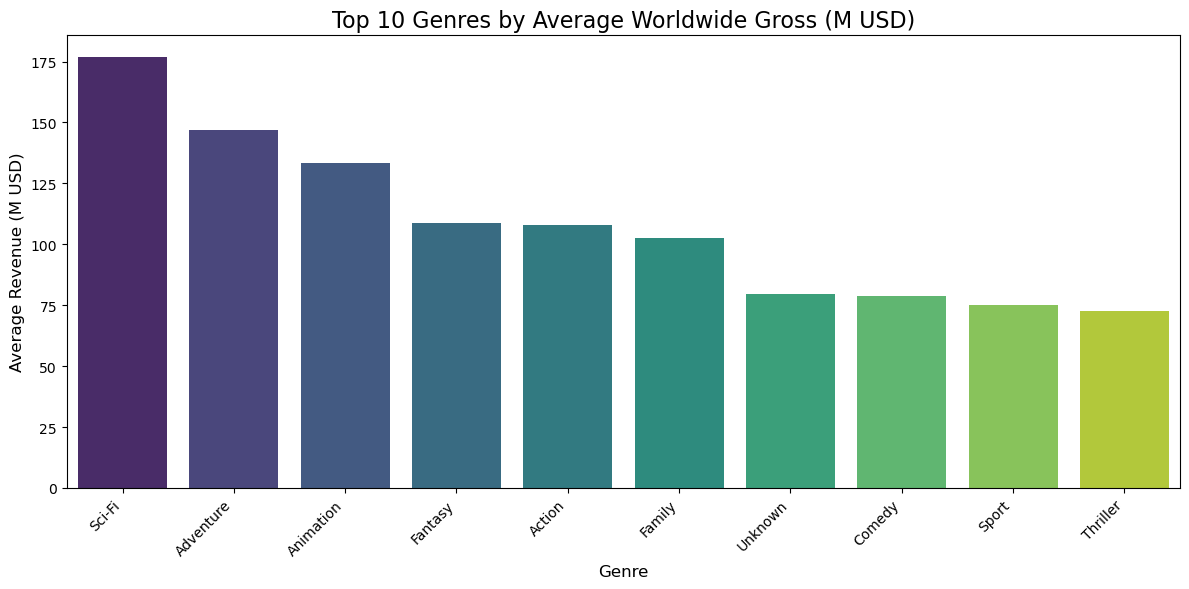

In [117]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_genres.index, y=top_10_genres.values, palette='viridis')
plt.title('Top 10 Genres by Average Worldwide Gross (M USD)', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Revenue (M USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

***Visualization 2: Rating vs. Revenue Scatter Plot***

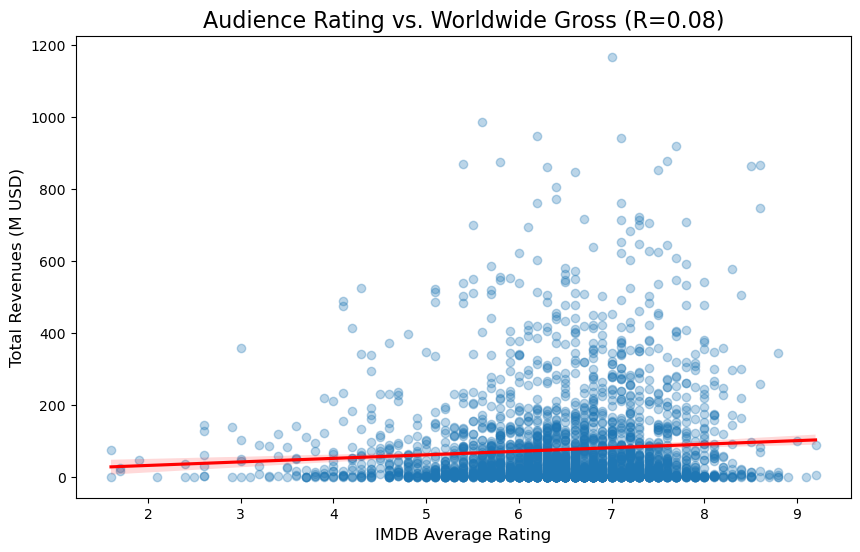

In [118]:
plt.figure(figsize=(10, 6))
# Add a regression line to show the trend 
sns.regplot(x='averagerating', y='Total_revenues_mil', data=df1, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title(f'Audience Rating vs. Worldwide Gross (R={correlation:.2f})', fontsize=16)
plt.xlabel('IMDB Average Rating', fontsize=12)
plt.ylabel('Total Revenues (M USD)', fontsize=12)
plt.show()

***Visualization 3: Runtime Revenue Trend Line Plot***

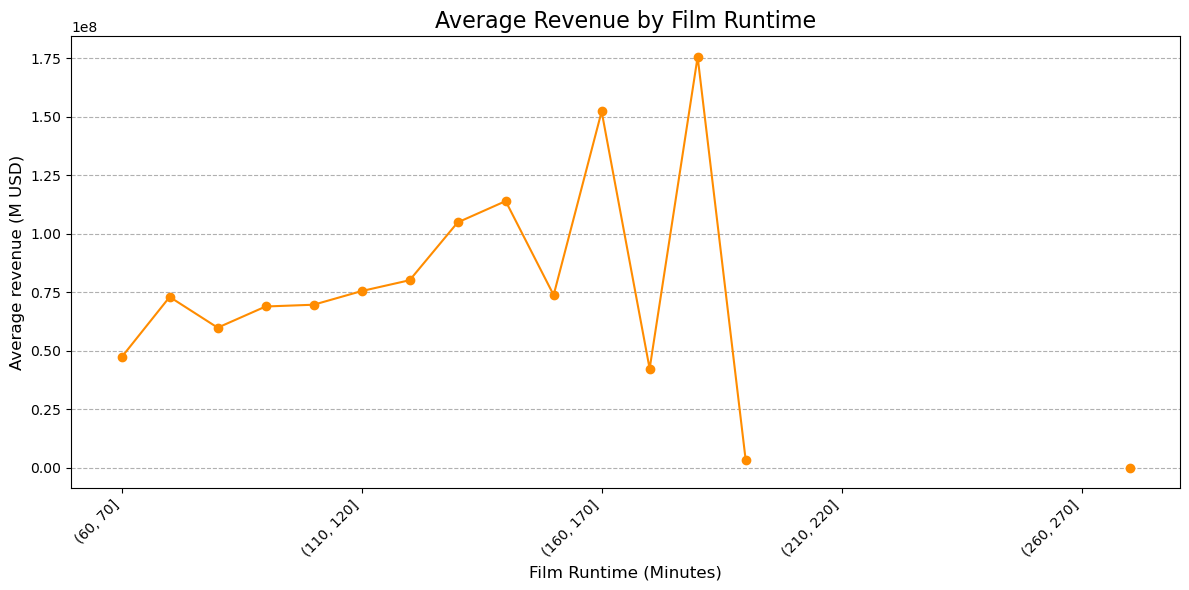

In [119]:
plt.figure(figsize=(12, 6))
runtime_revenue.plot(kind='line', marker='o', color='darkorange')
plt.title('Average Revenue by Film Runtime', fontsize=16)
plt.xlabel('Film Runtime (Minutes)', fontsize=12)
plt.ylabel('Average revenue (M USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

***Visualization 4: Rating Distribution for Top 10 Genres***

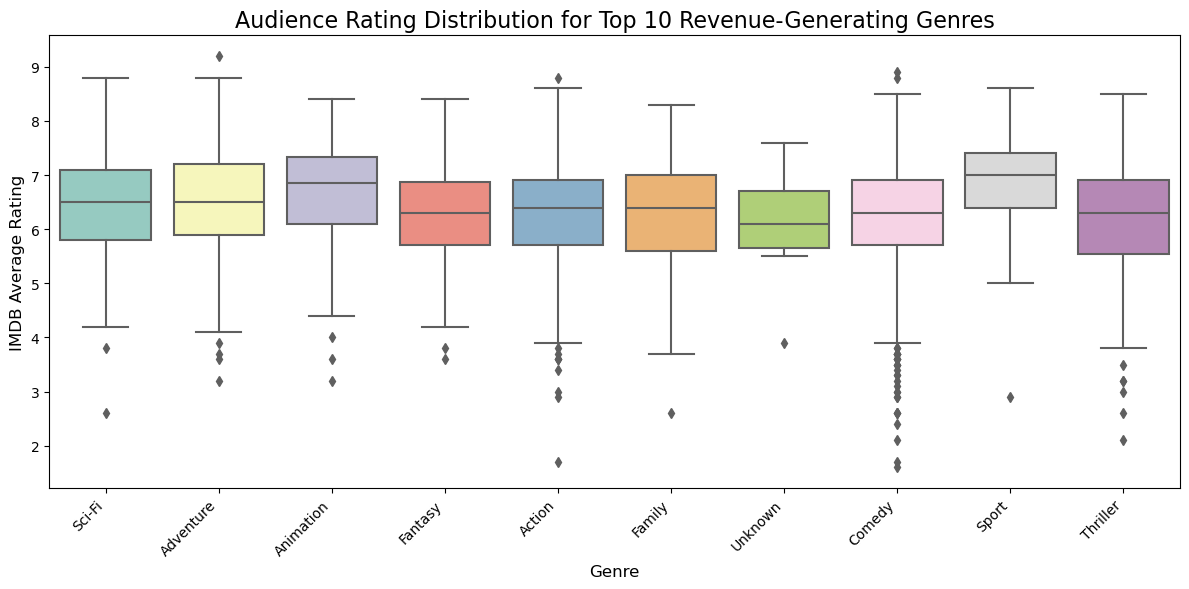

In [120]:
# Filter the exploded DataFrame to include only the top 10 average-earning genres
top_10_genre_list = top_10_genres.index.tolist()
df_top_genre_ratings = genre_exploded[genre_exploded['genres'].isin(top_10_genre_list)]
# Order the genres by their average revenue (same order as bar chart)
order = top_10_genres.index
plt.figure(figsize=(12, 6))
# Create a box plot to show the distribution of average ratings
sns.boxplot(x='genres', y='averagerating', data=df_top_genre_ratings, order=order, palette='Set3')
plt.title('Audience Rating Distribution for Top 10 Revenue-Generating Genres', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('IMDB Average Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **` 6. CONCLUSION AND RECOMMENDATIONS`**

***This analysis provides data-driven guidance on Genre, Runtime, and Rating to maximize worldwide box office revenue. The findings are based on integrating financial data with movie metadata, including genres, runtimes, and IMDB ratings.***

Key Findings Summary
- Average Revenue- The top-performing genres by average worldwide gross are Sci-Fi, Adventure, and Animation. These three genres represent the highest statistical probability for significant financial returns.

- Optimal Runtime- The highest average revenue is achieved by films in the 180–190 minute bracket. The commercial sweet spot, covering the broadest high-performing segments, is generally between 180 and 190 minutes.

- Rating Correlation- The correlation between IMDB Average Rating and Total Worldwide Gross is 0.17. This is a weak positive correlation, confirming that high critical or audience praise is not a reliable primary predictor of box office success.	

- Rating Consistency- While highly profitable, genres like Fantasy and Adventure often show significant volatility (wide interquartile range) in audience ratings, indicating a higher risk of producing a critically polarizing film. Genres like Animation, while also highly profitable, tend to show more consistent audience acceptance.

- Hypothesis Testing - One-Way ANOVA confirms a statistically significant difference in average revenue between major genres (p < 0.05). We Reject $H_0$ and confirm the genre ranking is not due to chance.

 **Actionable Recommendations for the Studio Head**

Based on the quantitative analysis, the following production strategy is recommended to optimize box office returns:

**1. Genre Investment Strategy**
* **Core Strategy Justification:** The decision to prioritize Sci-Fi, Adventure, and Animation is statistically validated. The One-Way ANOVA test confirmed that the differences in average revenue between these genres and others are highly significant, as the resulting $p < \alpha$ (where $\alpha=0.05$), leading us to reject the Null Hypothesis.
* **Prioritize Global Blockbusters:** Dedicate the majority of high-budget investment to projects in the **Sci-Fi** and **Adventure** genres. These areas exhibit the highest average revenue potential for worldwide success.
* **Invest in Quality Animation:** **Animation** should be viewed as a reliable high-yield, lower-risk genre. Its high profitability combined with generally consistent audience ratings makes it an ideal genre for building a stable franchise foundation.
* **Balance Risk (New Insight):** When developing projects in high-variance genres (like Fantasy), employ rigorous audience testing or minimize production budget exposure, as the revenue potential is high but the risk of critical/audience failure is also elevated.

 **2. Runtime Mandate**

* **Target the Sweet Spot:** Implement a production mandate to keep the majority of commercial features within the **180–190 minute** runtime range, with the ideal peak being near the **180–190 minute** segment. This range captures the most profitable segment of the market and maximizes efficient scheduling in theaters.
* **Avoid Lengthy Films:** Films significantly exceeding 200 minutes should be treated as high-risk exceptions, reserved only for flagship projects, as they generally yield lower average returns.

 **3. Strategy for Audience Rating**

* **Focus on Marketability Over Acclaim:** Given the **very weak positive correlation of 0.17** between rating and revenue, the studio should allocate resources more heavily toward **strategic global marketing and distribution** rather than relying on high critical acclaim to drive profits. The data shows that a slightly better rating offers only a negligible boost to the box office.
* **Use Rating as a Quality Floor:** While ratings don't drive revenue, projects should still target a baseline audience acceptance (e.g., aiming for a median rating of 6.0 or higher) to maintain brand credibility and mitigate negative word-of-mouth that could affect sequel performance.